# 利用可再生能源和储能技术最小化用电量

## 简介

随着太阳能和风能发电技术的普及,使用可再生能源已经变得越来越流行。然而,太阳并不总是照射,风也不总是吹动。客户需要能源的时间可能与风能和太阳能潜力高的时间不一致,这是可再生能源的一个关键挑战。电池可以成为这个问题的解决方案,通过放电使用储存的能源,可以在一天中的任何时间使用。

在本例中,我们将利用太阳能和电池储能来满足运营大学建筑和相关课程的能源需求。在接下来的部分中,我们将描述问题陈述,并演示如何使用数据科学和数学优化来最优地解决给定的问题。

本例使用的信息来自于[IEEE 预测+优化技术挑战赛](https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling)。

## 目标和前提条件

在本例中,我们考虑澳大利亚墨尔本一所大学校园内的一座建筑,在六天内(周一至周六)安排了一系列课程。

建筑物及其所举办的每门课程都有一定的能源需求需要满足。建筑物的能源需求假定为已知,每门课程根据所需资源(如班级规模或实验室)有不同的需求。该建筑安装了太阳能电池板,可以直接提供能源,同时也可以直接从电网购买电力来满足需求。此外,该建筑配备了两个电池,可以储存太阳能电池板提供的能源,并在需要时提供这些能源。我们也允许从电网为电池充电。

本例将时间序列数据预测与数学优化相结合,因为我们将把太阳能发电预测作为优化问题的关键输入。

## 问题陈述

在给定下周的课程安排和历史太阳能潜力数据的情况下,目标是确定最佳的电池充放电计划,以满足举办课程的建筑物的能源需求。总能源需求由建筑物本身的需求加上每门课程所需的能源组成。本例将考虑两个目标:
- 最小化下周从电网购买的总电量
- 由于电价波动,最小化从电网购买的电力总成本

同时,电池具有有限的容量以及在一段时间内可以充放电的限制。这些施加了问题的约束条件,使其难以解决。

为简单起见,每天考虑的时间将限制在早上5点到晚上8点之间。如果你通过我们的[学术项目](https://www.gurobi.com/academia/academic-program-and-licenses/)获得完整的Gurobi许可证,欢迎扩展这个问题来解决更大规模的版本。

这是一周的课程安排示意图:
![sched](ClassSchedule.png)

## 解决方案思路

问题的解决方案包括两个组成部分:1) **太阳能可用性预测组件** 和 2) **优化组件**,用于确定电池计划以及从电网购买的电量。

### 太阳能发电预测

预测组件已在本文件夹中的[energy_storage_ML](energy_storage_ML.ipynb)笔记本中完成。我们将使用该模型给出的预测,以及建筑物和每门课程的需求来制定和求解混合整数规划(MIP)问题,使用gurobipy为上述每个目标找到最优解。

我们首先安装和加载所需的软件包:

### 最优电池调度
现在我们有了太阳能发电预测,我们将创建一个优化模型,来调度两个电池的充放电以帮助满足建筑物和课程的能源需求。

有两个可以充放电的电池。因此,我们需要一个索引来描述每个电池的存在和运行。最后,鉴于我们希望以30分钟为间隔创建下个月的电池调度,我们也需要为时间段定义一个索引。

**集合**

$B = \{\texttt{Battery0, Battery1}\}$

$T = \{0,1,...,179\}$ 用于2020年10月的第一个周一至周六

**索引**

$b$: 表示电池(0或1)

$t$: 表示时间段(从0到179) 

In [1]:
# %pip install gurobipy
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

batteries = ["Battery0", "Battery1"]
path = 'https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/Modeling_Session_2/'
solar_values_read = pd.read_csv(path+'pred_solar_values.csv')
# solar_values_read = pd.read_csv('pred_solar_values.csv')
time_periods = range(len(solar_values_read))

### 输入参数

每个电池都有固定的储能容量,以及每30分钟周期内可以存储或放电的最大能量。

$c_{b}$: 电池 $b \in B$ 的容量 $uaduad \texttt{capacity[b]}$

$p_{b}$: 传输到电池 $b\in B$ 过程中的能量损耗(百分比) $uaduad \texttt{p}\_\texttt{loss[b]}$

$q_{b}$: 电池 $b \in B$ 的初始能量 $uaduad \texttt{initial[b]}$

$solar_{t}$: 时间段 $t \in T$ 的太阳能电池板发电量 $uaduad \texttt{solar}\_\texttt{values[b]}$

In [4]:
capacity = {"Battery0": 60, "Battery1": 80} # 单位: 千瓦
p_loss = {"Battery0": 0.95, "Battery1": 0.9} # 比例
initial = {"Battery0": 0, "Battery1": 0} # 单位: 千瓦

solar_values = round(solar_values_read.yhat,3)
solar_values.reset_index(drop = True, inplace = True)

特定时间段的能源需求来自两个来源 -- 建筑物和课程 -- 我们只关注总需求。这些数据将从外部文件读取,并且已经按时间段正确排序。

$d_{t}$: 时间段 $t\in T$ 的建筑物和课程总能源需求 $uaduad \texttt{total}\_\texttt{demand[t]}$

In [6]:
schedule = pd.read_csv(path+'schedule_demand.csv')
# schedule = pd.read_csv('schedule_demand.csv')
avg_building = pd.read_csv(path+'building_demand.csv')
# avg_building = pd.read_csv('building_demand.csv')
total_demand = schedule.sched_demand + avg_building.build_demand
print(f"Total Solar Generation: {solar_values.sum()} \nTotal Demand: {total_demand.sum()}")

Total Solar Generation: 4939.172 
Total Demand: 5250.6


### 决策变量

本问题的决策包括:
- 每个电池在给定时间段是充电还是放电
- 每个电池充放电多少
- 每个时间段的电池当前状态
- 以及从电网购买多少能源

令 $f^{in}_{b,t}$ 表示每个电池 $b$ 在时间段 $t$ 可以"充电"的量, $\forall b\in B, t\in T$。 $\quad\quad \texttt{flow}\_\texttt{in[b,t]}$

类似地,令 $f^{out}_{b,t}$ 表示每个电池"放电"的量。 $\quad\quad \texttt{flow}\_\texttt{out[b,t]}$

设定每个电池在单个时段内可以充电或放电的最大量为20千瓦。

In [9]:
m = gp.Model() #这定义了我们将在完成建模过程中添加内容的模型

flow_in = m.addVars(batteries, time_periods, name="flow_in") 
flow_out = m.addVars(batteries, time_periods, name="flow_out")

Set parameter LicenseID to value 2601452


接下来,每个时间段从电网购买的能源量。我们假设这是一个非负数,并且我们不能"卖回"电网(尽管这也是一个有趣的问题!)

$grid_{t}$ : 该变量表示在时间段 $t$ 从电网购买的能源量, $\forall t \in T$

In [10]:
grid = m.addVars(time_periods, name="grid")

接下来的两组决策变量将有稍微不同的感觉。我们需要跟踪每个时间段内每个电池的能量(即其状态),并跟踪使用了多少太阳能(通过充电或直接供能)。

$s_{b,t}$ 是时间段 $t$ 结束时电池 $b$ 的当前能量, $\forall b\in B, t\in T$。 $\quad\texttt{state[b,t]}$

$gen_{t}$ 是时间段 $t$ 使用的可用太阳能量, $\forall t \in T$。 $\quad\texttt{gen[t]}$


In [11]:
state = m.addVars(batteries, time_periods, name="state") 
gen = m.addVars(time_periods, name="gen")

最后要添加的决策变量将处理一个可能在此类问题中出现的棘手情况 -- 电池不能同时充电和放电。因此,我们需要确保每个电池在每个时间段内将执行以下三种操作之一: 1. **充电**, 2. **放电**, 或 3. **都不做**。

为此,我们为每个时间段引入一个二进制变量, $z_{b,t}, \forall b \in B, t \in T$, 我们称之为 $\texttt{zwitch}\_\texttt{[b,t]}$。为什么叫*zwitch*? 这是我从早期优化建模开始就做的事情,因为在MO中常用的单字母二进制变量是 $z$。这个变量就像开关 -- 因此,称为*zwitch*。

In [12]:
zwitch = m.addVars(batteries, time_periods, vtype=GRB.BINARY, name="zwitch")

### 约束条件
在每个时间段内,我们需要确保满足能源需求。可用能源可以来自三个来源: 1) 电网, 2) 太阳能电池板, 或 3) 电池放电。此外,我们可能决定为电池充电,这将有助于满足后期的需求。

$$
\begin{align*} 
\sum_b(f^{out}_{b,t}-p_bf^{in}_{b,t}) + gen_t + grid_t = d_t \quad \forall t \in T
\end{align*}
$$

In [13]:
m.addConstrs((gp.quicksum(flow_out[b,t] - p_loss[b]*flow_in[b,t] for b in batteries) + gen[t] + grid[t] == total_demand[t] 
                  for t in time_periods), name="power_balance")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

每个时间段的电池状态会影响后续状态,以及每个电池的充放电决策。因此,一般来说,电池在时间 $t$ 的状态是前一时间段的状态以及任何充放电。

为此,我们根据每个电池的初始能量设置初始状态,以及第一个时间段的充放电决策。

\begin{equation}
s_{b,0} = q_b + p_bf^{in}_{b,0} - f^{out}_{b,0}
\end{equation}

对于之后的每个时间段(即 $t\ge1$),电池的状态由以下公式确定:

\begin{equation}
s_{b,t} = s_{b,t-1} + p_bf^{in}_{b,t} - f^{out}_{b,t}, t \ge 1
\end{equation}

相应的约束条件可以写成如下。

In [14]:
m.addConstrs((state[b,0] == initial[b] + p_loss[b]*flow_in[b,0] - flow_out[b,0] for b in batteries), name="initial_state")
m.addConstrs((state[b,t] == state[b,t-1] + p_loss[b]*flow_in[b,t] - flow_out[b,t] for b in batteries for t in time_periods if t >= 1), name="subsequent_states");

太阳能的可用性可以用于三个地方:
1. Battery0
2. Battery1
3. 直接满足需求

因此,我们需要限制电池的充电量以及直接用于需求的量。

$$
\begin{equation}
f^{in}_{\texttt{Battery0},t} + f^{in}_{\texttt{Battery1},t} + gen_t \le solar_t, \quad \forall t \in T
\end{equation}
$$

In [15]:
m.addConstrs((flow_in['Battery0',t] + flow_in['Battery1',t] + gen[t] <= solar_values[t] for t in time_periods), name = "solar_avail")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### 二进制变量建模逻辑
使用二进制变量来建模这里的选择可能是数学优化建模中最困难的部分。它归结为使用零、一和不等式来表示一个复杂的系统。获得正确的逻辑需要时间,并且需要大量迭代来确保正确完成。总之,如果你觉得这部分困难,不要担心。

让我们先制定约束条件,然后深入探讨它们为什么有效。

$$
\begin{align*} 
f^{in}_{b,t} &\leq 20*z_{b,t} &\forall b \in B, t \in T \\
f^{out}_{b,t} &\leq 20*(1-z_{b,t}) &\forall b \in B, t \in T
\end{align*}
$$

为了说明其工作原理,让我们考虑一个示例 -- 假设在一个时间段内,某个电池 $f^{in}_{b,t} = 10$。为了使第一个不等式成立,必须 $z_{b,t} = 1$, 否则 $20*0 = 0$, 这不可能发生如果 $f^{in}_{b,t} = 10$。然后在同一时间段,如果 $z_{b,t} = 1$, 则 $1-z_{b,t} = 0$。这迫使第二个不等式的右侧为 $0$, 这迫使 $f^{out}_{b,t} = 0$, 使其在此期间无法放电。类似的逻辑适用于电池在一个时间段内放电的情况(即假设 $f^{out}_{b,t} = 10$)。

由于我们的`zwitch`是一个二进制变量,这意味着每个时间段的两种情况之一将始终发生。重要的问题是 -- 这是一个问题吗? 答案是否定的,因为我们需要担心的是我们的不等式*强制*决策变量是什么。考虑 $f^{in}_{b,t} = f^{in}_{b,t} = 0$ 的情况,这意味着电池既不充电也不放电,因为流入和流出为零。这种情况不会违反上述任何一个不等式,并且不管 $z$ 取什么值 -- 它可以是 $0$ 或 $1$, 不等式都成立。

这确实提出了一个重要的问题。如果在解决此问题后有人问你"电池充电和放电的时间段是多少?" 很容易认为 $z_{b,t} = 1$ 意味着电池正在充电,因此只需将这些加起来即可得到充电时间段的数量。然后计算 $z_{b,t} = 0$ 的次数以获得放电计数。鉴于我们看到 $f^{in}_{b,t} = f^{in}_{b,t} = 0$ 的情况,这将是*不正确的*。

20 是从哪里来的? 这是电池在一个时间段内可以充电或放电的上限。

In [16]:
m.addConstrs((flow_in[b,t] <= 20*zwitch[b,t] for b in batteries for t in time_periods), name = "to_charge")
m.addConstrs((flow_out[b,t] <= 20*(1-zwitch[b,t]) for b in batteries for t in time_periods), name = "or_not_to_charge");

最后,我们需要设置每个电池可以存储的最大量,这意味着电池的*状态*必须有上限。这些上限可以在使用`addVars()`时在变量定义中设置。在添加变量时设置边界通常更有效。

In [17]:
for b, t in state:
    state[b,t].UB = capacity[b]

$$
\begin{align*} 
s_{b,t} \le c_b, \quad \forall b \in B
\end{align*}
$$

### 目标函数

目标是最小化所有时间段内从电网购买的总能量。

\begin{equation}
{\rm minimize} \quad \sum_{t} grid_{t}
\end{equation}

In [18]:
m.setObjective(gp.quicksum(grid[t] for t in time_periods), GRB.MINIMIZE)

### 求解优化模型和输出分析
现在模型已经设置完成,我们可以优化以实现最小的电力购买量。

In [19]:
m.optimize()
print(f"Total energy purchased from the grid: {round(m.objVal,3)} kWh")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0xaa31bb6a
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
Found heuristic solution: objective 5250.6000000
Presolve removed 84 rows and 265 columns
Presolve time: 0.01s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Found heuristic solution: objective 4986.0960000
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 1.281678e+03, 603 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

让我们现在看看一些决策变量的值。使用*getAttr*函数和*'X'*参数来获取`state`决策变量的值。

In [20]:
sol_in = pd.Series(m.getAttr('X',flow_in))
sol_out = pd.Series(m.getAttr('X',flow_out))
sol_level = pd.Series(m.getAttr('X',state))

print(f"Periods Battery0 charges: {sum(sol_in['Battery0'] > 0)}")
print(f"Periods Battery1 charges: {sum(sol_in['Battery1'] > 0)}")
print(f"Periods Battery0 discharges: {sum(sol_out['Battery0'] > 0)}")
print(f"Periods Battery1 discharges: {sum(sol_out['Battery1'] > 0)}")

Periods Battery0 charges: 50
Periods Battery1 charges: 27
Periods Battery0 discharges: 49
Periods Battery1 discharges: 20


每个电池状态随时间的变化图:

Periods at Battery0 at Full Capacity: 18
Periods at Battery1 at Full Capacity: 11


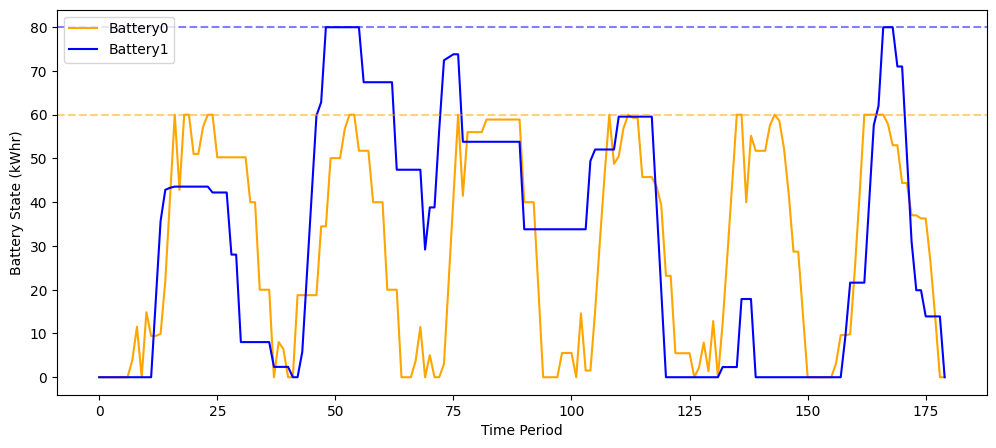

In [21]:
plt.figure(figsize=(12,5))
s0, = plt.plot(sol_level['Battery0'], c = 'orange')
s1, = plt.plot(sol_level['Battery1'], c = 'blue')
plt.ylabel('Battery State (kWhr)')
plt.xlabel('Time Period')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level['Battery1']==capacity['Battery1'])}");

使用默认的容量值,较小容量的电池(Battery0)仅在两次达到其容量,而Battery1更频繁地达到其限制。更改这些值将如何改变优化?

我们最后一组决策变量是从电网购买的电量,其总量在目标中被最小化,并在时间上绘制出来。

Proportion of time periods where electrity is purchaced from the grid: 0.433


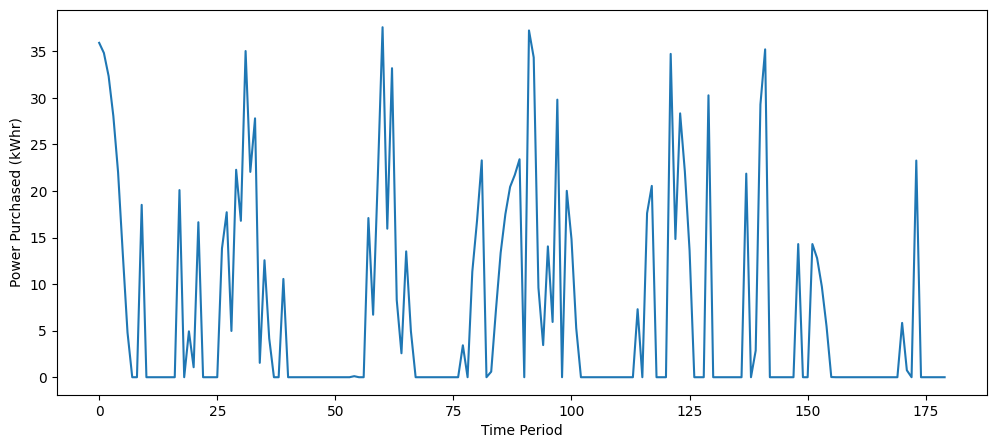

In [22]:
sol_grid = pd.Series(m.getAttr('X',grid))
plt.figure(figsize=(12,5))
plt.plot(sol_grid)
plt.ylabel('Power Purchased (kWhr)')
plt.xlabel('Time Period');
print(f"Proportion of time periods where electrity is purchaced from the grid: {round(sum(sol_grid > 0)/len(sol_grid),3)}")

上面计算了从电网购买电力的时间段数。这与最小化购买的总量相同吗? 如果不是(提示,不是!),你会如何建模? (另一个提示,这将需要额外的二进制变量)
### 更改目标函数
如示例开始时所述,我们将考虑两个目标函数,第二个是最小化购买电力的成本。为此,我们需要每个时间段的预期价格。

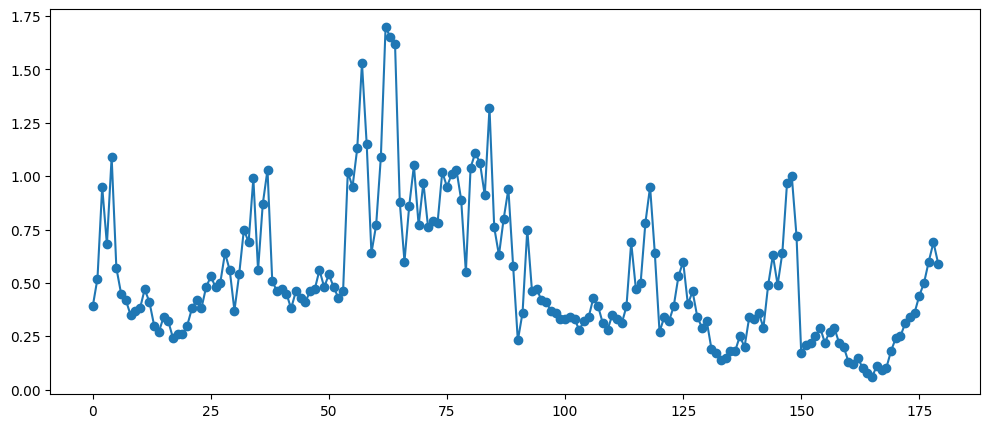

In [24]:
avg_price = pd.read_csv(path+'expected_price.csv')
# avg_price = pd.read_csv('expected_price.csv')
plt.figure(figsize=(12,5))
plt.plot(avg_price.index, avg_price.price, '-o');

要更改目标,只需再次设置即可。模型的其余部分保持不变,因此不需要进一步调整。

In [25]:
m.setObjective(gp.quicksum(avg_price.price[time]*grid[time] for time in time_periods), GRB.MINIMIZE)

In [26]:
m.optimize() # 再次运行优化
print(f"Energy cost for the week: ${round(m.objVal,2)}")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x66bddde2
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

MIP start from previous solve produced solution with objective 607.227 (0.02s)
Loaded MIP start from previous solve with objective 607.227

Presolve removed 84 rows and 265 columns
Presolve time: 0.01s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 6.019761e+02, 769 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective

我们可以像之前一样提取决策变量,看看给定新目标的解决方案如何变化。

Periods at Battery0 at Full Capacity: 26
Periods at Battery1 at Full Capacity: 18


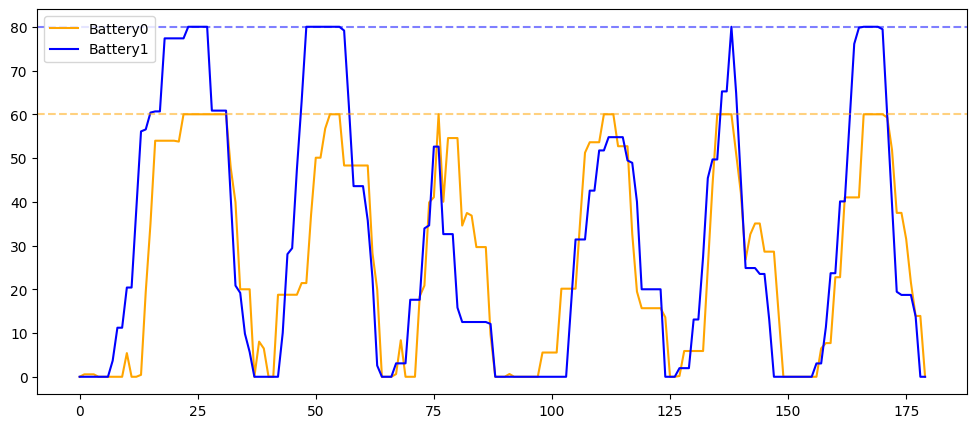

In [27]:
sol_level_cost = pd.Series(m.getAttr('X',state))
plt.figure(figsize=(12,5))
plt.plot(sol_level_cost['Battery0'], c ='orange')
plt.plot(sol_level_cost['Battery1'], c ='blue')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level_cost['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level_cost['Battery1']==capacity['Battery1'])}");

我们看到每个电池花费更多时间充满或接近充满,特别是Battery0。这表明添加成本将使电池保留电力,然后在成本最高的时间段内放电。

以下是一些深入探讨此问题的后续问题:
- 更改目标后从电网购买了多少电力?
- 给定第二个目标的价格,第一个最小化购买电力的解决方案的成本是多少?
- 在第二个目标中增加Battery0的容量将如何改变解决方案?

<h2>结论</h2>

本例演示了如何建模一个利用太阳能可用性时间序列预测的能源系统。建模此类系统的部分挑战在于一个时间段的决策如何影响下一个时间段。我们还研究了定义决策变量边界的两种方法,并看到更新目标函数非常简单,可能会对解决方案产生重大影响。在Gurobi广泛的[笔记本示例](https://www.gurobi.com/resource/modeling-examples-using-the-gurobi-python-api-in-jupyter-notebook/)中还有更多[能源相关](https://www.gurobi.com/resource/electrical-power-generation-jupyter-notebook-i-and-ii/)的示例。

版权所有 © 2022 Gurobi Optimization, LLC